<a href="https://colab.research.google.com/github/misanchz98/bitcoin-direction-prediction/blob/main/03_modeling/03_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Modelos de Deep Learning para Series Temporales con Walk-Forward Validation

En este notebook implementamos diferentes modelos de **Deep Learning** y técnicas de validación temporal con **Purged Walk-Forward Split**.  

Incluye:
- Preprocesamiento y creación de secuencias.
- Modelos: LSTM, GRU, CNN-LSTM, Transformer y TCN.
- Métricas personalizadas y evaluación.
- Importancia de características.
- Pipeline de entrenamiento y validación.

## 🔹 1. Librerías
Instalamos e importamos las librerías necesarias para manipulación de datos, visualización, machine learning y deep learning.


In [306]:
#!pip install boruta
#!pip install keras-tcn --quiet

In [307]:
# =============================================================================
# LIBRERIAS
# =============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef)

from sklearn.model_selection import BaseCrossValidator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D,
                                     Flatten, Input, LayerNormalization)
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback
import warnings

# Establecer el nivel de advertencias a "ignore" para ignorar todas las advertencias
warnings.filterwarnings("ignore")

## 🔹 2. Semillas
Para garantizar **reproducibilidad** en los experimentos, es importante fijar las semillas de las librerías que generan números aleatorios:

- `os.environ['PYTHONHASHSEED']` → controla el hash en Python.  
- `numpy.random.seed` → asegura resultados reproducibles en operaciones de NumPy.  
- `random.seed` → fija la semilla del generador de números aleatorios nativo de Python.  
- `tf.random.set_seed` → fija la semilla para TensorFlow y Keras.  

Esto ayuda a que los modelos se entrenen con resultados consistentes entre ejecuciones.

In [308]:
# resetting the seeds for reproducibility
def reset_random_seeds():
    n = 42
    os.environ['PYTHONHASHSEED'] = str(n)
    tf.random.set_seed(n)
    np.random.seed(n)
    random.seed(n)

reset_random_seeds()

## 🔹 3. Conjunto de Datos
Importamos el conjunto de datos en nuestro entorno de trabajo. Se encuentran almacenados en un archivo CSV llamado `btc_historical_data_eda.csv`, cuya obtención se explica en el *notebook* `02_data_analysis.ipynb`.

In [309]:
# Importamos CSV
url = 'https://raw.githubusercontent.com/misanchz98/bitcoin-direction-prediction/main/02_data_analysis/data/btc_historical_data_eda.csv'
df_bitcoin = pd.read_csv(url, parse_dates=['Open time'])
df_bitcoin

,Open time,Close,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Range,Candle,Target,CMF_20,MFI_14,...,c2_ta_tendencia,c3_ta_tendencia,c1_ta_momentum,c2_ta_momentum,c3_ta_momentum,c4_ta_momentum,c5_ta_momentum,c1_ta_volatilidad,c2_ta_volatilidad,c3_ta_volatilidad
0,2017-10-05,4292.43,9158.0,351.042019,1.483037e+06,245.00,83.84,1,0.081329,56.225018,...,1.426309,-0.136861,1.317719,-0.126726,-1.676720,1.289633,0.019128,-4.644643,-0.938175,-0.259897
1,2017-10-06,4369.00,6546.0,226.148177,9.881066e+05,125.00,50.01,1,0.090972,62.048701,...,1.684975,-0.223654,1.843789,-0.313902,-0.766032,1.200655,0.108543,-4.656021,-1.404483,-0.298095
2,2017-10-07,4423.00,4804.0,145.313076,6.371469e+05,166.94,54.00,1,0.072898,60.780168,...,1.837639,-0.272101,1.714315,0.851111,-1.474281,-0.169404,-0.611932,-4.658149,-1.694457,-0.310605
3,2017-10-08,4640.00,7580.0,280.094854,1.268661e+06,233.00,215.00,1,0.064115,66.225272,...,2.655718,-0.595153,4.539268,-1.327677,-1.397994,0.344940,0.095779,-4.643444,-2.930102,-0.299058
4,2017-10-09,4786.95,10372.0,350.756559,1.654275e+06,339.98,146.95,0,0.105281,66.423592,...,3.068594,-0.711866,4.065484,0.284535,-0.496135,-0.373562,-0.383308,-4.619178,-3.116037,-0.259659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,2025-08-16,117380.66,1179842.0,2995.228650,3.521588e+08,755.01,38.62,1,-0.078079,61.679789,...,-2.974279,-0.597347,-1.738575,-0.246759,0.045690,1.947962,-0.826190,11.130802,0.715864,-3.617415
2873,2025-08-17,117405.01,1177563.0,2804.731130,3.307994e+08,1402.79,24.35,0,-0.071478,61.441782,...,-3.056170,-0.520901,-2.679964,0.452454,-1.078307,1.833305,-0.382838,11.062656,0.708259,-3.717682
2874,2025-08-18,116227.05,3345487.0,7647.218200,8.850528e+08,2903.61,-1177.96,0,-0.058026,54.527915,...,-3.371373,-0.335897,-3.708156,1.216496,-0.767095,1.913662,1.633951,11.085307,1.427748,-3.651715
2875,2025-08-19,112872.94,3291170.0,8609.360780,9.840874e+08,3993.11,-3354.11,1,-0.133646,53.037041,...,-4.158761,0.112011,-5.328226,0.713262,0.105456,1.232647,-1.954862,11.229262,3.161925,-3.269720


## 🔹 4. Split Purgado Walk-Forward

Definimos un validador temporal con **embargo** para evitar fugas de información y simular un escenario *walk-forward*.

### 📘 Purged Time Series Split

La técnica **Purged Time Series Split** se utiliza para realizar validación cruzada en series temporales, evitando fugas de información entre entrenamiento y validación.

#### 🧠 ¿Por qué es necesaria?

En series temporales (como datos financieros), los datos futuros **no deben influir** en el entrenamiento del modelo. Usar validación cruzada tradicional puede provocar que el modelo aprenda de datos que cronológicamente ocurren después de los datos de validación, lo que genera resultados engañosos.

#### 🔍 ¿Qué significa "purged"?

Se eliminan (purge) los datos cercanos al conjunto de validación del conjunto de entrenamiento para evitar que el modelo aprenda patrones que están demasiado próximos en el tiempo y puedan estar correlacionados.

#### ⏳ ¿Qué es el "embargo"?

Es una zona de exclusión temporal entre el final del conjunto de entrenamiento y el inicio del conjunto de validación. Sirve para evitar que eventos cercanos contaminen el entrenamiento.

|--- entrenamiento ---| embargo |--- validación ---|

#### ✅ Ventajas

- Evita **data leakage** (fugas de información).
- Simula condiciones reales de predicción.
- Mejora la **validez del modelo** en contextos temporales como mercados financieros.

Esta técnica es especialmente útil cuando se trabaja con datos como precios de Bitcoin, donde el orden temporal y la independencia entre conjuntos es crítica.

In [310]:
# =======================================
# SPLIT PURGADO WALK-FORWARD
# =======================================

import itertools as itt
import numbers
import numpy as np
import pandas as pd

from abc import abstractmethod
from typing import Iterable, Tuple, List


import itertools as itt
import numbers
import numpy as np
import pandas as pd

from abc import abstractmethod
from typing import Iterable, Tuple, List


class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.

    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).

    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.

    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        if not pred_times.equals(pred_times.sort_values()):
            raise ValueError('pred_times should be sorted')
        if not eval_times.equals(eval_times.sort_values()):
            raise ValueError('eval_times should be sorted')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])


class PurgedWalkForwardCV(BaseTimeSeriesCrossValidator):
    """
    Purged walk-forward cross-validation

    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.

    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits contiguous folds are used as the test set, while the train set consists in between
    min_train_splits and max_train_splits immediately preceding folds.

    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.)

    With split_by_times = True in the split method, it is also possible to split the samples in folds spanning equal
    time intervals (using the prediction time as a time tag), instead of folds containing equal numbers of samples.

    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.

    n_test_splits : int, default = 1
        Number of folds used in the test set. Must be at least 1.

    min_train_splits: int, default = 2
        Minimal number of folds to be used in the train set.

    max_train_splits: int, default = None
        Maximal number of folds to be used in the train set. If None, there is no upper limit.

    """
    def __init__(self, n_splits=10, n_test_splits=1, min_train_splits=2, max_train_splits=None):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits >= self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits

        if not isinstance(min_train_splits, numbers.Integral):
            raise ValueError(f"The minimal number of train folds must be of Integral type. {min_train_splits} of type "
                             f"{type(min_train_splits)} was passed.")
        min_train_splits = int(min_train_splits)
        if min_train_splits <= 0 or min_train_splits >= self.n_splits - self.n_test_splits:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"min_train_splits between 1 and n_splits - n_test_splits, got min_train_splits = "
                             f"{min_train_splits}.")
        self.min_train_splits = min_train_splits

        if max_train_splits is None:
            max_train_splits = self.n_splits - self.n_test_splits
        if not isinstance(max_train_splits, numbers.Integral):
            raise ValueError(f"The maximal number of train folds must be of Integral type. {max_train_splits} of type "
                             f"{type(max_train_splits)} was passed.")
        max_train_splits = int(max_train_splits)
        if max_train_splits <= 0 or max_train_splits > self.n_splits - self.n_test_splits:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"max_train_split between 1 and n_splits - n_test_splits, got max_train_split = "
                             f"{max_train_splits}.")
        self.max_train_splits = max_train_splits
        self.fold_bounds = []

    def split(self, X: pd.DataFrame, y: pd.Series = None, pred_times: pd.Series = None, eval_times: pd.Series = None,
              split_by_time: bool = False) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.

        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.

        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.

        y : pd.Series, not used, inherited from _BaseKFold

        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.

        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.

        split_by_time: bool
            If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
            time intervals.

        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.

        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.

        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        self.fold_bounds = compute_fold_bounds(self, split_by_time)

        count_folds = 0
        for fold_bound in self.fold_bounds:
            if count_folds < self.min_train_splits:
                count_folds = count_folds + 1
                continue
            if self.n_splits - count_folds < self.n_test_splits:
                break
            # Computes the bounds of the test set, and the corresponding indices
            test_indices = self.compute_test_set(fold_bound, count_folds)
            # Computes the train set indices
            train_indices = self.compute_train_set(fold_bound, count_folds)

            count_folds = count_folds + 1
            yield train_indices, test_indices

    def compute_train_set(self, fold_bound: int, count_folds: int) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.

        Parameters
        ----------
        fold_bound : int
            Bound between the train set and the test set.

        count_folds : int
            The number (starting at 0) of the first fold in the test set.

        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.

        """
        if count_folds > self.max_train_splits:
            start_train = self.fold_bounds[count_folds - self.max_train_splits]
        else:
            start_train = 0
        train_indices = np.arange(start_train, fold_bound)
        # Purge
        train_indices = purge(self, train_indices, fold_bound, self.indices[-1])
        return train_indices

    def compute_test_set(self, fold_bound: int, count_folds: int) -> np.ndarray:
        """
        Compute the indices of the samples in the test set.

        Parameters
        ----------
        fold_bound : int
            Bound between the train set and the test set.

        count_folds : int
            The number (starting at 0) of the first fold in the test set.

        Returns
        -------
        test_indices: np.ndarray
            A numpy array containing the test indices.

        """
        if self.n_splits - count_folds > self.n_test_splits:
            end_test = self.fold_bounds[count_folds + self.n_test_splits]
        else:
            end_test = self.indices[-1] + 1
        return np.arange(fold_bound, end_test)


class CombPurgedKFoldCV(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation

    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.

    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.

    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.

    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.

    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.

    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).

    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=pd.Timedelta(minutes=0)):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits
        if not isinstance(embargo_td, pd.Timedelta):
            raise ValueError(f"The embargo time should be of type Pandas Timedelta. {embargo_td} of type "
                             f"{type(embargo_td)} was passed.")
        if embargo_td < pd.Timedelta(minutes=0):
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.

        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.

        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.

        y : pd.Series, not used, inherited from _BaseKFold

        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.

        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.

        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.

        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.

        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))
        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.

        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.

        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.

        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.

        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.

        Parameters
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.

        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but with the neighboring folds in the test set merged.

        test_indices: np.ndarray
            A numpy array containing the test indices.

        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices


def compute_fold_bounds(cv: BaseTimeSeriesCrossValidator, split_by_time: bool) -> List[int]:
    """
    Compute a list containing the fold (left) boundaries.

    Parameters
    ----------
    cv: BaseTimeSeriesCrossValidator
        Cross-validation object for which the bounds need to be computed.
    split_by_time: bool
        If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
        time intervals.
    """
    if split_by_time:
        full_time_span = cv.pred_times.max() - cv.pred_times.min()
        fold_time_span = full_time_span / cv.n_splits
        fold_bounds_times = [cv.pred_times.iloc[0] + fold_time_span * n for n in range(cv.n_splits)]
        return cv.pred_times.searchsorted(fold_bounds_times)
    else:
        return [fold[0] for fold in np.array_split(cv.indices, cv.n_splits)]


def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.

    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.

    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.

    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.

    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.

    test_fold_end : int
        Index corresponding to the end of a test set block.

    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.

    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[test_indices[test_indices <= test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """
    Purge part of the train set.

    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.

    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.

    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.

    test_fold_start : int
        Index corresponding to the start of a test set block.

    test_fold_end : int
        Index corresponding to the end of the same test set block.

    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.

    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])
    return np.concatenate((train_indices_1, train_indices_2))

#class PurgedTimeSeriesSplit(BaseCrossValidator):
#    def __init__(self, n_splits=4, embargo=0, test_size=0.2):
#        self.n_splits = n_splits
#        self.embargo = embargo
#        self.test_size = test_size
#
#    def split(self, X, y=None, groups=None):
#        n_samples = len(X)
#        test_size = int(n_samples * self.test_size)
#        n_trainval = n_samples - test_size
#        fold_sizes = np.linspace(0.5, 1.0, self.n_splits+1)
#
#        for i in range(self.n_splits):
#            end = int(fold_sizes[i+1] * n_trainval)
#            val_size = int(0.15 * end)
#            val_start = end - val_size
#            val_end = end
#            train_end = max(0, val_start - self.embargo)
#            train_idx = np.arange(0, train_end)
#            val_idx = np.arange(val_start, val_end)
#
#            yield train_idx, val_idx
#
#    def get_n_splits(self, X=None, y=None, groups=None):
#        return self.n_splits

#class PurgedCV:
#    def __init__(self, embargo_size=0):
#        self.embargo_size = embargo_size
#
#    def split(self, X, events):
#        """
#        Generate purged and embargoed cross-validation splits.
#        - X: array de secuencias (no se usa directamente aquí, pero se mantiene por compatibilidad)
#        - events: Series con índice de fechas y labels (ej. Target)
#        """
#        events = events.sort_index()
#        unique_dates = events.index.unique()
#        n_splits = len(unique_dates)
#
#        for test_date in unique_dates:
#            # Test = todos los eventos en esa fecha
#            test_indices = events.index == test_date
#
#            # Train = todo lo demás, menos embargo
#            train_indices = self._get_train_indices(events, test_date, self.embargo_size)
#            yield train_indices, test_indices
#

#    def _get_train_indices(events, test_date, embargo_size):
#        train_indices = events.index != test_date
#        if embargo_size > 0:
#            embargo_dates = pd.date_range(
#                start=test_date,
#                periods=embargo_size + 1,
#                freq=events.index.freq  # necesita DateTimeIndex con freq definida
#            )
#            train_indices &= ~events.index.isin(embargo_dates)
#        return train_indices

## 🔹 4. SharpeCallback


In [311]:
class SharpeCallback(Callback):
    def __init__(self, X_val, y_val, returns_val, threshold=0.5, verbose=1):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.returns_val = returns_val
        self.threshold = threshold
        self.verbose = verbose
        self.best_sharpe = -np.inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.X_val) > self.threshold).astype(int)
        strat_returns = np.where(y_pred.flatten() == 1, self.returns_val, 0)  # solo largos
        sharpe = strat_returns.mean() / (strat_returns.std() + 1e-8) * np.sqrt(252)  # anualizado aproximado
        logs["sharpe"] = sharpe
        if self.verbose > 0:
            print(f" - val_sharpe: {sharpe:.4f}")
        if sharpe > self.best_sharpe:
            self.best_sharpe = sharpe
            self.best_weights = self.model.get_weights()


## 🔹 5. Creación de Secuencias

Función para crear ventanas deslizantes en series temporales multivariadas.

In [312]:
# =======================================
# CREACIÓN DE SECUENCIAS
# =======================================

def create_windows_multivariate_np(data, target, window_size, horizon=1, shuffle=False):
    if isinstance(data, pd.DataFrame):
        data = data.values
    if isinstance(target, (pd.DataFrame, pd.Series)):
        target = target.values

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size, :])
        y.append(target[i+window_size+horizon-1])

    X, y = np.array(X), np.array(y)

    if shuffle:
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        X, y = X[idx], y[idx]

    return X, y

## 🔹 6. Modelos Base

Definimos diferentes arquitecturas:
- **LSTM**
- **GRU**
- **CNN+LSTM**
- **CNN+GRU**

In [313]:
# =======================================
# MODELOS BASE
# =======================================
# --- Build modelos parametrizables ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

# --- LSTM simple ---
def build_lstm(input_shape, lstm_units=64, dropout=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, input_shape=input_shape, return_sequences=False),
        Dropout(dropout),
        Dense(32, activation="relu"),
        Dropout(dropout),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC()])
    return model

# --- GRU simple ---
def build_gru(input_shape, lstm_units=64, dropout=0.2, learning_rate=0.001):
    model = Sequential([
        GRU(lstm_units, input_shape=input_shape, return_sequences=False),
        Dropout(dropout),
        Dense(32, activation="relu"),
        Dropout(dropout),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC()])
    return model

# --- LSTM + CNN ---
def build_lstm_cnn(input_shape, lstm_units=32, cnn_filters=32, kernel_size=3, dropout=0.2, learning_rate=0.001):
    model = Sequential([
        Conv1D(cnn_filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(lstm_units, return_sequences=False),
        Dropout(dropout),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC()])
    return model

# --- GRU + CNN ---
def build_gru_cnn(input_shape, lstm_units=32, cnn_filters=32, kernel_size=3, dropout=0.2, learning_rate=0.001):
    model = Sequential([
        Conv1D(cnn_filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        GRU(lstm_units, return_sequences=False),
        Dropout(dropout),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC()])
    return model


## 🔹 7. Evaluación de Métricas

Función para calcular métricas de clasificación y métricas financieras (retorno y Sharpe ratio).

In [314]:
# =======================================
# EVALUACIÓN DE MÉTRICAS
# =======================================

def evaluate_metrics(y_true, y_pred, returns=None):
    base_metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "mcc": matthews_corrcoef(y_true, y_pred)
    }

    results = {"base": base_metrics}

    if returns is not None:
        strategies = {
            "longshort": np.where(y_pred == 1, returns, -returns),
            "longonly":  np.where(y_pred == 1, returns, 0),
            "shortonly": np.where(y_pred == 0, -returns, 0)
        }

        for strat_name, strat_returns in strategies.items():
            strat_metrics = base_metrics.copy()
            strat_metrics.update({
                "cum_return": strat_returns.cumsum()[-1],
                "sharpe": strat_returns.mean() / (strat_returns.std() + 1e-8)
            })
            results[strat_name] = strat_metrics

    return results

## 🔹 10. Resumen de Métricas

Funciones para resumir y visualizar resultados de los modelos.

In [315]:
# =======================================
# RESUMEN DE MÉTRICAS
# =======================================

def summarize_results(metrics_df):
    summary = metrics_df.groupby("model").agg(["mean", "std"])
    summary = summary.sort_values(("f1", "mean"), ascending=False)
    return summary.round(4)

def aggregate_feature_importances(feature_importances_all, top_n=10):
    agg_results = {}
    for model_name in set([d["model"] for d in feature_importances_all]):
        imps = [d["importances"] for d in feature_importances_all if d["model"] == model_name]
        if imps:
            imp_mean = pd.concat(imps, axis=1).mean(axis=1).sort_values(ascending=False)
            agg_results[model_name] = imp_mean.head(top_n)
            plt.figure(figsize=(8,5))
            imp_mean.head(top_n).plot(kind="barh")
            plt.gca().invert_yaxis()
            plt.title(f"Top-{top_n} Features ({model_name})")
            plt.show()
    return agg_results

def plot_feature_importance_heatmap(feature_importances_all, top_n=10):
    agg_results = aggregate_feature_importances(feature_importances_all, top_n)
    df_heatmap = pd.DataFrame(agg_results).fillna(0)
    plt.figure(figsize=(10,6))
    sns.heatmap(df_heatmap, annot=True, fmt=".3f", cmap="YlOrBr")
    plt.title(f"Heatmap Features vs Modelos (Top-{top_n})")
    plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# === Boxplots por modelo y métrica ===
def plot_boxplots(results_df):
    metrics_to_plot = ["accuracy", "precision", "recall", "f1", "mcc", "cum_return", "sharpe"]

    for metric in metrics_to_plot:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x="model", y=metric, data=results_df, palette="Set2")
        sns.stripplot(x="model", y=metric, data=results_df,
                      color="black", alpha=0.6, jitter=True)  # puntos de cada fold
        plt.title(f"Distribución de {metric} por modelo")
        plt.ylabel(metric)
        plt.xlabel("Modelo")
        plt.grid(True, alpha=0.3)
        plt.show()

## 🔹 11. *Pipeline Walk-Forward*
*Pipeline* que entrena múltiples modelos, evalúa métricas y calcula importancia de features.

In [316]:
# =======================================
# IMPORTS
# =======================================
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, List, Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =======================================
# CREACIÓN DE SECUENCIAS
# =======================================

def create_windows_multivariate_np(data, target, window_size, horizon=1, shuffle=False):
    """
    Crea secuencias multivariadas para redes neuronales.
    Devuelve X shape (n_samples, window_size, n_features) y y shape (n_samples,).
    """
    if isinstance(data, pd.DataFrame):
        data = data.values
    if isinstance(target, (pd.DataFrame, pd.Series)):
        target = target.values

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size, :])
        y.append(target[i+window_size+horizon-1])

    X, y = np.array(X), np.array(y)

    if shuffle:
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        X, y = X[idx], y[idx]

    return X, y

# =======================================
# CALLBACK PERSONALIZADO PARA SHARPE
# =======================================

class SharpeCallback(tf.keras.callbacks.Callback):
    """
    Callback que monitorea el ratio de Sharpe durante el entrenamiento,
    guarda los mejores pesos según Sharpe y expone el histórico de Sharpe por época.
    """
    def __init__(self, X_val, y_val, returns_val, threshold=0.5, strategy='longonly', verbose=1):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.returns_val = returns_val
        self.threshold = threshold
        self.strategy = strategy
        self.verbose = verbose
        self.best_sharpe = -np.inf
        self.best_weights = None
        self.sharpe_history = []

    def _calculate_sharpe(self, y_pred, returns):
        """Calcula Sharpe anualizado según la estrategia."""
        returns = np.array(returns)
        y_pred = np.array(y_pred)

        if self.strategy == 'longonly':
            strategy_returns = np.where(y_pred == 1, returns, 0)
        elif self.strategy == 'longshort':
            strategy_returns = np.where(y_pred == 1, returns, -returns)
        elif self.strategy == 'shortonly':
            strategy_returns = np.where(y_pred == 0, -returns, 0)
        else:
            strategy_returns = np.where(y_pred == 1, returns, 0)

        if len(strategy_returns) == 0 or strategy_returns.std() <= 1e-8:
            return 0.0

        return strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

    def on_epoch_end(self, epoch, logs=None):
        # Predicción sobre validación y cálculo de Sharpe
        y_pred_proba = self.model.predict(self.X_val, verbose=0)
        y_pred = (y_pred_proba > self.threshold).astype(int)

        sharpe = self._calculate_sharpe(y_pred.flatten(), self.returns_val)

        if logs is None:
            logs = {}
        logs["val_sharpe"] = sharpe
        self.sharpe_history.append(sharpe)

        if self.verbose > 0:
            print(f" - val_sharpe: {sharpe:.4f}")

        if sharpe > self.best_sharpe:
            self.best_sharpe = sharpe
            self.best_weights = self.model.get_weights()

    def restore_best_weights(self):
        """Restaura los mejores pesos guardados (si existen)."""
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)

# =======================================
# EVALUACIÓN DE MÉTRICAS FINANCIERAS
# =======================================

def calculate_max_drawdown(cumulative_returns):
    """Calcula el máximo drawdown a partir de cumulative_returns (array)."""
    if len(cumulative_returns) == 0:
        return 0.0

    cumulative_returns = np.array(cumulative_returns)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - running_max
    return np.min(drawdown) if len(drawdown) > 0 else 0.0

def evaluate_metrics(y_true, y_pred, returns=None):
    """
    Evalúa métricas de clasificación y, si se provee returns, métricas de estrategia.
    Devuelve diccionario con 'base' y por cada estrategia (longshort, longonly, shortonly).
    """
    base_metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "mcc": matthews_corrcoef(y_true, y_pred)
    }

    results = {"base": base_metrics}

    if returns is not None:
        returns = np.array(returns)
        strategies = {
            "longshort": np.where(y_pred == 1, returns, -returns),
            "longonly":  np.where(y_pred == 1, returns, 0),
            "shortonly": np.where(y_pred == 0, -returns, 0)
        }

        for strat_name, strat_returns in strategies.items():
            strat_metrics = base_metrics.copy()

            if len(strat_returns) > 0:
                cum_return = np.cumsum(strat_returns)[-1]
                mean_return = np.mean(strat_returns)
                std_return = np.std(strat_returns)

                if std_return > 1e-8:
                    sharpe = mean_return / std_return * np.sqrt(252)
                else:
                    sharpe = 0.0

                max_dd = calculate_max_drawdown(np.cumsum(strat_returns))
                win_rate = np.sum(strat_returns > 0) / len(strat_returns) if len(strat_returns) > 0 else 0

                strat_metrics.update({
                    "cum_return": cum_return,
                    "mean_return": mean_return,
                    "volatility": std_return,
                    "sharpe": sharpe,
                    "max_drawdown": max_dd,
                    "win_rate": win_rate,
                    "num_trades": np.sum(y_pred != 0) if strat_name != "longshort" else len(y_pred)
                })
            else:
                strat_metrics.update({
                    "cum_return": 0.0, "mean_return": 0.0, "volatility": 0.0,
                    "sharpe": 0.0, "max_drawdown": 0.0, "win_rate": 0.0, "num_trades": 0
                })

            results[strat_name] = strat_metrics

    return results

# =======================================
# CLASE PRINCIPAL: TimeSeriesRandomSearchCV
# =======================================

class TimeSeriesRandomSearchCV:
    """
    Clase que implementa Random Search combinado con Purged Walk-Forward CV
    Guarda por cada combinación: mean_score, std_score, n_folds, fold_scores y los hyperparams.
    """
    def __init__(self,
                 param_grid: Dict,
                 cv_params: Dict = None,
                 n_iter: int = 10,
                 scoring: str = 'sharpe',
                 strategy: str = 'longonly',
                 random_state: int = 42):

        self.param_grid = param_grid
        self.n_iter = n_iter
        self.scoring = scoring
        self.strategy = strategy
        self.random_state = random_state

        self.cv_params = cv_params or {
            'n_splits': 5,
            'n_test_splits': 1,
            'min_train_splits': 2
        }

        self.results_ = []
        self.best_params_ = None
        self.best_score_ = -np.inf

        random.seed(random_state)
        np.random.seed(random_state)
        tf.random.set_seed(random_state)

    def _generate_param_combinations(self) -> List[Dict]:
        """Genera n_iter combinaciones aleatorias (puede haber repeticiones)."""
        combinations = []
        for _ in range(self.n_iter):
            combination = {}
            for param, values in self.param_grid.items():
                combination[param] = random.choice(values)
            combinations.append(combination)
        return combinations

    def _create_model(self, model_type: str, input_shape: Tuple, params: Dict):
        """Crea modelo según tipo."""
        if model_type == 'LSTM':
            return self._build_lstm(input_shape, **params)
        elif model_type == 'GRU':
            return self._build_gru(input_shape, **params)
        elif model_type == 'LSTM_CNN':
            return self._build_lstm_cnn(input_shape, **params)
        elif model_type == 'GRU_CNN':
            return self._build_gru_cnn(input_shape, **params)
        else:
            raise ValueError(f"Tipo de modelo no soportado: {model_type}")

    def _build_lstm(self, input_shape, lstm_units=64, dropout=0.2, learning_rate=0.001, **kwargs):
        model = Sequential([
            LSTM(lstm_units, input_shape=input_shape, return_sequences=False),
            Dropout(dropout),
            Dense(32, activation="relu"),
            Dropout(dropout),
            Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=['accuracy'])
        return model

    def _build_gru(self, input_shape, lstm_units=64, dropout=0.2, learning_rate=0.001, **kwargs):
        model = Sequential([
            GRU(lstm_units, input_shape=input_shape, return_sequences=False),
            Dropout(dropout),
            Dense(32, activation="relu"),
            Dropout(dropout),
            Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=['accuracy'])
        return model

    def _build_lstm_cnn(self, input_shape, lstm_units=32, cnn_filters=32, kernel_size=3, dropout=0.2, learning_rate=0.001, **kwargs):
        model = Sequential([
            Conv1D(cnn_filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            LSTM(lstm_units, return_sequences=False),
            Dropout(dropout),
            Dense(16, activation="relu"),
            Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=['accuracy'])
        return model

    def _build_gru_cnn(self, input_shape, lstm_units=32, cnn_filters=32, kernel_size=3, dropout=0.2, learning_rate=0.001, **kwargs):
        model = Sequential([
            Conv1D(cnn_filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            GRU(lstm_units, return_sequences=False),
            Dropout(dropout),
            Dense(16, activation="relu"),
            Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=['accuracy'])
        return model

    def _calculate_sharpe_ratio(self, y_true, y_pred, returns, strategy=None):
        """
        Calcula Sharpe anualizado para la predicción y_pred y returns.
        (El parámetro y_true está aquí por compatibilidad pero no se usa para Sharpe).
        """
        if strategy is None:
            strategy = self.strategy
        if len(returns) == 0:
            return 0.0

        returns = np.array(returns)
        y_pred = np.array(y_pred)

        if strategy == 'longonly':
            strategy_returns = np.where(y_pred == 1, returns, 0)
        elif strategy == 'longshort':
            strategy_returns = np.where(y_pred == 1, returns, -returns)
        elif strategy == 'shortonly':
            strategy_returns = np.where(y_pred == 0, -returns, 0)
        else:
            strategy_returns = np.where(y_pred == 1, returns, 0)

        if len(strategy_returns) == 0 or strategy_returns.std() <= 1e-8:
            return 0.0

        mean_return = strategy_returns.mean()
        std_return = strategy_returns.std()
        return mean_return / std_return * np.sqrt(252)

    def _evaluate_fold(self, y_true, y_pred, returns):
        """Devuelve métricas base y sharpe calculado."""
        base_metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'sharpe': self._calculate_sharpe_ratio(y_true, y_pred, returns)
        }
        return base_metrics

    def fit(self, X, y, pred_times, eval_times, returns, model_types=['LSTM', 'GRU']):
        """
        Ejecuta Random Search con PurgedWalkForwardCV (se asume que tienes disponible esa clase).
        Guarda por combinación: mean_score, std_score, n_folds, fold_scores y los hyperparams.
        """

        df_index = pd.DataFrame(index=pred_times.index)
        y_series = pd.Series(y, index=pred_times.index)

        param_combinations = self._generate_param_combinations()

        print(f"Ejecutando Random Search con {self.n_iter} combinaciones y {len(model_types)} modelos...")
        print(f"Estrategia de trading: {self.strategy}")
        print(f"Métrica de optimización: {self.scoring}")

        cv = PurgedWalkForwardCV(**self.cv_params)

        total_iterations = len(param_combinations) * len(model_types)
        current_iteration = 0

        for param_idx, params in enumerate(param_combinations):
            print(f"\nCombinación {param_idx + 1}/{len(param_combinations)}: {params}")

            for model_type in model_types:
                current_iteration += 1
                print(f"  Evaluando {model_type} ({current_iteration}/{total_iterations})")

                fold_scores = []

                for fold, (train_idx, val_idx) in enumerate(cv.split(X=df_index, y=y_series, pred_times=pred_times, eval_times=eval_times)):

                    if len(val_idx) < 20 or len(train_idx) < 50:
                        # Evitar folds demasiado pequeños
                        continue

                    # Preparar datos del fold
                    X_train, y_train = X[train_idx], y[train_idx]
                    X_val, y_val = X[val_idx], y[val_idx]
                    returns_val = returns[val_idx]

                    # Escalado por feature (fit en train, transform en val)
                    scaler = StandardScaler()
                    n_samples, seq_len, n_features = X_train.shape

                    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(n_samples, seq_len, n_features)
                    X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape[0], seq_len, n_features)

                    try:
                        # Crear y entrenar modelo
                        model = self._create_model(model_type, X_train.shape[1:], params)

                        # Callbacks incluyendo el SharpeCallback
                        sharpe_callback = SharpeCallback(X_val_scaled, y_val, returns_val, threshold=0.5, strategy=self.strategy, verbose=0)
                        callbacks = [
                            EarlyStopping(monitor="val_sharpe", patience=7, mode='max', restore_best_weights=False),
                            ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6),
                            sharpe_callback
                        ]

                        model.fit(
                            X_train_scaled, y_train,
                            validation_data=(X_val_scaled, y_val),
                            epochs=params.get('epochs', 50),
                            batch_size=params.get('batch_size', 32),
                            callbacks=callbacks,
                            verbose=0
                        )

                        # Restaurar los mejores pesos según el callback Sharpe
                        sharpe_callback.restore_best_weights()

                        # Predicción y evaluación del fold
                        y_pred_proba = model.predict(X_val_scaled, verbose=0).ravel()
                        y_pred = (y_pred_proba > 0.5).astype(int)

                        fold_metrics = self._evaluate_fold(y_val, y_pred, returns_val)

                        if self.scoring == 'sharpe':
                            # Preferir el best_sharpe encontrado por el callback si existe
                            score = sharpe_callback.best_sharpe if hasattr(sharpe_callback, 'best_sharpe') and sharpe_callback.best_sharpe > -np.inf else fold_metrics.get('sharpe', 0)
                        else:
                            score = fold_metrics.get(self.scoring, 0)

                        fold_scores.append(score)

                    except Exception as e:
                        print(f"    Error en fold {fold}: {str(e)}")
                        continue

                # Guardar resultado por combinación si hay folds válidos
                if fold_scores:
                    mean_score = np.mean(fold_scores)
                    std_score = np.std(fold_scores)

                    result = {
                        'model_type': model_type,
                        'mean_score': mean_score,
                        'std_score': std_score,
                        'n_folds': len(fold_scores),
                        'strategy': self.strategy,
                        'fold_scores': fold_scores,
                        **params
                    }
                    self.results_.append(result)

                    if mean_score > self.best_score_:
                        self.best_score_ = mean_score
                        self.best_params_ = {
                            'model_type': model_type,
                            'strategy': self.strategy,
                            **params
                        }

                    print(f"    Score: {mean_score:.4f} ± {std_score:.4f} (n_folds={len(fold_scores)})")
                else:
                    print(f"    Sin resultados válidos para {model_type}")

        print(f"\nMejor configuración encontrada:")
        print(f"Score ({self.scoring}): {self.best_score_:.4f}")
        print(f"Estrategia: {self.strategy}")
        print(f"Parámetros: {self.best_params_}")

        return self

    def get_results_df(self):
        """Retorna DataFrame con todos los resultados (cada fila = una combinación)."""
        return pd.DataFrame(self.results_)

    def plot_results(self, figsize=(15, 12)):
        """
        Genera visualizaciones SOLO de las gráficas 3 a 6:
        - Para cada modelo: boxplot donde cada caja = una combinación (usa fold_scores)
        - Debajo de cada boxplot se dibuja una tabla con mean_score y std_score por combinación
        """
        if not self.results_:
            print("No hay resultados para mostrar. Ejecuta fit() primero.")
            return

        results_df = self.get_results_df()

        # Solo 4 subplots (2 filas x 2 columnas)
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(
            f'Random Search - Estrategia: {getattr(self, "strategy", "N/A").upper()} | Métrica: {self.scoring.upper()}',
            fontsize=16
        )

        model_types = ['LSTM', 'GRU', 'LSTM_CNN', 'GRU_CNN']
        positions = [(0,0), (0,1), (1,0), (1,1)]

        for model_type, pos in zip(model_types, positions):
            model_data = results_df[results_df['model_type'] == model_type].reset_index(drop=True)
            ax = axes[pos]

            if not model_data.empty:
                # Extraer scores por fold de cada combinación
                fold_scores_list = model_data['fold_scores'].tolist()
                labels = [f"comb_{i+1}" for i in range(len(fold_scores_list))]

                # Boxplot
                ax.boxplot(fold_scores_list, labels=labels, showmeans=True)
                ax.set_title(f'{model_type} - Boxplots por Combinación ({len(labels)} combos)')
                ax.set_ylabel(f'{self.scoring.title()} (por fold)')
                ax.set_xlabel('')
                ax.tick_params(axis='x', rotation=45)

                # ======= TABLA con mean y std de cada combinación ==========
                table_data = []
                for i, row in model_data.iterrows():
                    table_data.append([
                        f"{model_type}_comb{i+1}",
                        f"{row['mean_score']:.4f}",
                        f"{row['std_score']:.4f}"
                    ])

                table = ax.table(
                    cellText=table_data,
                    colLabels=['Modelo', 'Mean Score', 'Std Score'],
                    cellLoc='center',
                    loc='bottom',
                    bbox=[0, -0.45, 1, 0.35]  # ajusta la posición y altura
                )
                table.auto_set_font_size(False)
                table.set_fontsize(8)
            else:
                ax.text(
                    0.5, 0.5, f'Sin datos\npara {model_type}',
                    transform=ax.transAxes, ha='center', va='center',
                    fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
                )
                ax.set_title(f'{model_type} - Sin datos')
                ax.set_xticks([])
                ax.set_yticks([])

        plt.tight_layout()
        plt.show()



# =======================================
# FUNCIÓN PRINCIPAL PARA EJECUTAR TODO
# =======================================

def run_time_series_random_search(df, target_col='Target', return_col='Return',
                                 window_size=30, horizon=1, test_size=0.2,
                                 strategy='longonly', scoring='sharpe', n_iter=20):
    """
    Ejecuta el pipeline completo: prepara datos, genera secuencias, corre Random Search y plotea resultados.
    Devuelve la instancia TimeSeriesRandomSearchCV con los resultados en .results_.
    """
    print(f"Configuración del experimento:")
    print(f"  Estrategia: {strategy}")
    print(f"  Métrica: {scoring}")
    print(f"  Iteraciones: {n_iter}")

    # Separar train/test (simple split temporal)
    n_test = int(len(df) * test_size)
    df_train = df.iloc[:-n_test]

    feature_cols = [c for c in df.columns if c not in [target_col, return_col]]
    X_raw = df_train[feature_cols].values
    y_raw = df_train[target_col].values
    returns_raw = df_train[return_col].values

    # Crear secuencias
    X_seq, y_seq = create_windows_multivariate_np(X_raw, y_raw, window_size, horizon)
    returns_seq = returns_raw[window_size + horizon - 1:]

    # Índices temporales para PurgedWalkForwardCV
    seq_indices = df_train.index[window_size + horizon - 1:]
    pred_times = pd.Series(seq_indices, index=seq_indices)
    eval_times = pd.Series(seq_indices + pd.Timedelta(hours=horizon), index=seq_indices)

    # Grid de hiperparámetros
    param_grid = {
        'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
        'batch_size': [16, 32, 64],
        'epochs': [20, 30, 50],
        'dropout': [0.1, 0.2, 0.3],
        'lstm_units': [32, 64, 128],
        'cnn_filters': [16, 32, 64],
        'kernel_size': [2, 3, 5]
    }

    # Instanciar Random Search
    random_search = TimeSeriesRandomSearchCV(
        param_grid=param_grid,
        n_iter=n_iter,
        scoring=scoring,
        strategy=strategy,
        cv_params={
            'n_splits': 5,
            'n_test_splits': 1,
            'min_train_splits': 2
        }
    )

    model_types = ['LSTM', 'GRU', 'LSTM_CNN', 'GRU_CNN']

    # Ejecutar búsqueda
    random_search.fit(
        X=X_seq,
        y=y_seq,
        pred_times=pred_times,
        eval_times=eval_times,
        returns=returns_seq,
        model_types=model_types
    )

    # Plotear resultados
    random_search.plot_results()

    return random_search



In [317]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Dense, Dropout
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#import itertools
#import random
#from typing import Dict, List, Tuple, Any
#import warnings
#warnings.filterwarnings('ignore')
#
#
#class TimeSeriesRandomSearchCV:
#    """
#    Clase que combina Random Search con PurgedWalkForwardCV para redes neuronales
#    """
#
#    def __init__(self,
#                 param_grid: Dict,
#                 cv_params: Dict = None,
#                 n_iter: int = 10,
#                 scoring: str = 'sharpe',
#                 random_state: int = 42):
#
#        self.param_grid = param_grid
#        self.n_iter = n_iter
#        self.scoring = scoring
#        self.random_state = random_state
#
#        # Parámetros por defecto para CV
#        self.cv_params = cv_params or {
#            'n_splits': 5,
#            'n_test_splits': 1,
#            'min_train_splits': 2
#        }
#
#        # Almacenar resultados
#        self.results_ = []
#        self.best_params_ = None
#        self.best_score_ = -np.inf
#
#        random.seed(random_state)
#        np.random.seed(random_state)
#        tf.random.set_seed(random_state)
#
#    def _generate_param_combinations(self) -> List[Dict]:
#        """Genera combinaciones aleatorias de hiperparámetros"""
#        combinations = []
#
#        for _ in range(self.n_iter):
#            combination = {}
#            for param, values in self.param_grid.items():
#                combination[param] = random.choice(values)
#            combinations.append(combination)
#
#        return combinations
#
#    def _create_model(self, model_type: str, input_shape: Tuple, params: Dict):
#        """Crea modelo según el tipo y parámetros"""
#
#        if model_type == 'LSTM':
#            return self._build_lstm(input_shape, **params)
#        elif model_type == 'GRU':
#            return self._build_gru(input_shape, **params)
#        elif model_type == 'LSTM_CNN':
#            return self._build_lstm_cnn(input_shape, **params)
#        elif model_type == 'GRU_CNN':
#            return self._build_gru_cnn(input_shape, **params)
#        else:
#            raise ValueError(f"Tipo de modelo no soportado: {model_type}")
#
#    def _build_lstm(self, input_shape, lstm_units=64, dropout=0.2, learning_rate=0.001, **kwargs):
#        """Construye modelo LSTM"""
#        model = Sequential([
#            LSTM(lstm_units, input_shape=input_shape, return_sequences=False),
#            Dropout(dropout),
#            Dense(32, activation="relu"),
#            Dropout(dropout),
#            Dense(1, activation="sigmoid")
#        ])
#
#        model.compile(
#            optimizer=Adam(learning_rate=learning_rate),
#            loss="binary_crossentropy",
#            metrics=['accuracy']
#        )
#        return model
#
#    def _build_gru(self, input_shape, lstm_units=64, dropout=0.2, learning_rate=0.001, **kwargs):
#        """Construye modelo GRU"""
#        model = Sequential([
#            GRU(lstm_units, input_shape=input_shape, return_sequences=False),
#            Dropout(dropout),
#            Dense(32, activation="relu"),
#            Dropout(dropout),
#            Dense(1, activation="sigmoid")
#        ])
#
#        model.compile(
#            optimizer=Adam(learning_rate=learning_rate),
#            loss="binary_crossentropy",
#            metrics=['accuracy']
#        )
#        return model
#
#    def _build_lstm_cnn(self, input_shape, lstm_units=32, cnn_filters=32,
#                       kernel_size=3, dropout=0.2, learning_rate=0.001, **kwargs):
#        """Construye modelo LSTM+CNN"""
#        model = Sequential([
#            Conv1D(cnn_filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
#            MaxPooling1D(pool_size=2),
#            LSTM(lstm_units, return_sequences=False),
#            Dropout(dropout),
#            Dense(16, activation="relu"),
#            Dense(1, activation="sigmoid")
#        ])
#
#        model.compile(
#            optimizer=Adam(learning_rate=learning_rate),
#            loss="binary_crossentropy",
#            metrics=['accuracy']
#        )
#        return model
#
#    def _build_gru_cnn(self, input_shape, lstm_units=32, cnn_filters=32,
#                      kernel_size=3, dropout=0.2, learning_rate=0.001, **kwargs):
#        """Construye modelo GRU+CNN"""
#        model = Sequential([
#            Conv1D(cnn_filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
#            MaxPooling1D(pool_size=2),
#            GRU(lstm_units, return_sequences=False),
#            Dropout(dropout),
#            Dense(16, activation="relu"),
#            Dense(1, activation="sigmoid")
#        ])
#
#        model.compile(
#            optimizer=Adam(learning_rate=learning_rate),
#            loss="binary_crossentropy",
#            metrics=['accuracy']
#        )
#        return model
#
#    def _calculate_sharpe_ratio(self, y_true, y_pred, returns):
#        """Calcula el ratio de Sharpe"""
#        if len(returns) == 0:
#            return 0.0
#
#        strategy_returns = returns * y_pred
#        if strategy_returns.std() == 0:
#            return 0.0
#
#        return strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
#
#    def _evaluate_fold(self, y_true, y_pred, returns):
#        """Evalúa un fold individual"""
#        metrics = {
#            'accuracy': accuracy_score(y_true, y_pred),
#            'f1': f1_score(y_true, y_pred, zero_division=0),
#            'precision': precision_score(y_true, y_pred, zero_division=0),
#            'recall': recall_score(y_true, y_pred, zero_division=0),
#            'sharpe': self._calculate_sharpe_ratio(y_true, y_pred, returns)
#        }
#        return metrics
#
#    def fit(self, X, y, pred_times, eval_times, returns, model_types=['LSTM', 'GRU']):
#        """
#        Ejecuta el Random Search con validación cruzada
#
#        Parameters:
#        -----------
#        X : array-like, shape (n_samples, n_timesteps, n_features)
#            Datos de entrada (secuencias)
#        y : array-like, shape (n_samples,)
#            Variable objetivo
#        pred_times : pd.Series
#            Tiempos de predicción
#        eval_times : pd.Series
#            Tiempos de evaluación
#        returns : array-like
#            Retornos para calcular Sharpe
#        model_types : list
#            Tipos de modelos a evaluar
#        """
#
#        # Crear DataFrame para CV
#        df_index = pd.DataFrame(index=pred_times.index)
#        y_series = pd.Series(y, index=pred_times.index)
#
#        # Generar combinaciones de hiperparámetros
#        param_combinations = self._generate_param_combinations()
#
#        print(f"Ejecutando Random Search con {self.n_iter} combinaciones y {len(model_types)} modelos...")
#
#        # Inicializar CV
#        cv = PurgedWalkForwardCV(**self.cv_params)
#
#        total_iterations = len(param_combinations) * len(model_types)
#        current_iteration = 0
#
#        for param_idx, params in enumerate(param_combinations):
#            print(f"\nCombinación {param_idx + 1}/{len(param_combinations)}: {params}")
#
#            for model_type in model_types:
#                current_iteration += 1
#                print(f"  Evaluando {model_type} ({current_iteration}/{total_iterations})")
#
#                fold_scores = []
#
#                # CV Loop
#                for fold, (train_idx, val_idx) in enumerate(cv.split(
#                    X=df_index, y=y_series, pred_times=pred_times, eval_times=eval_times
#                )):
#
#                    if len(val_idx) < 20 or len(train_idx) < 50:
#                        continue
#
#                    # Preparar datos
#                    X_train, y_train = X[train_idx], y[train_idx]
#                    X_val, y_val = X[val_idx], y[val_idx]
#                    returns_val = returns[val_idx]
#
#                    # Escalado
#                    scaler = StandardScaler()
#                    n_samples, seq_len, n_features = X_train.shape
#
#                    X_train_scaled = scaler.fit_transform(
#                        X_train.reshape(-1, n_features)
#                    ).reshape(n_samples, seq_len, n_features)
#
#                    X_val_scaled = scaler.transform(
#                        X_val.reshape(-1, n_features)
#                    ).reshape(X_val.shape[0], seq_len, n_features)
#
#                    try:
#                        # Crear y entrenar modelo
#                        model = self._create_model(model_type, X_train.shape[1:], params)
#
#                        # Callbacks
#                        callbacks = [
#                            EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
#                            ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6)
#                        ]
#
#                        # Entrenar
#                        history = model.fit(
#                            X_train_scaled, y_train,
#                            validation_data=(X_val_scaled, y_val),
#                            epochs=params.get('epochs', 50),
#                            batch_size=params.get('batch_size', 32),
#                            callbacks=callbacks,
#                            verbose=0
#                        )
#
#                        # Predicción
#                        y_pred_proba = model.predict(X_val_scaled, verbose=0).ravel()
#                        y_pred = (y_pred_proba > 0.5).astype(int)
#
#                        # Evaluar fold
#                        fold_metrics = self._evaluate_fold(y_val, y_pred, returns_val)
#                        fold_scores.append(fold_metrics[self.scoring])
#
#                    except Exception as e:
#                        print(f"    Error en fold {fold}: {str(e)}")
#                        continue
#
#                # Calcular score promedio
#                if fold_scores:
#                    mean_score = np.mean(fold_scores)
#                    std_score = np.std(fold_scores)
#
#                    # Guardar resultado
#                    result = {
#                        'model_type': model_type,
#                        'mean_score': mean_score,
#                        'std_score': std_score,
#                        'n_folds': len(fold_scores),
#                        **params
#                    }
#                    self.results_.append(result)
#
#                    # Actualizar mejor resultado
#                    if mean_score > self.best_score_:
#                        self.best_score_ = mean_score
#                        self.best_params_ = {
#                            'model_type': model_type,
#                            **params
#                        }
#
#                    print(f"    Score: {mean_score:.4f} ± {std_score:.4f}")
#                else:
#                    print(f"    Sin resultados válidos para {model_type}")
#
#        print(f"\nMejor configuración encontrada:")
#        print(f"Score: {self.best_score_:.4f}")
#        print(f"Parámetros: {self.best_params_}")
#
#        return self
#
#    def get_results_df(self):
#        """Retorna DataFrame con todos los resultados"""
#        return pd.DataFrame(self.results_)
#
#    def plot_results(self, figsize=(15, 10)):
#        """Genera visualizaciones de los resultados con 4 boxplots por modelo"""
#        if not self.results_:
#            print("No hay resultados para mostrar. Ejecuta fit() primero.")
#            return
#
#        results_df = self.get_results_df()
#
#        # Crear subplots en grid 2x3
#        fig, axes = plt.subplots(2, 3, figsize=figsize)
#        fig.suptitle('Resultados del Random Search - Análisis por Modelo', fontsize=16)
#
#        # 1. Boxplot general por modelo
#        sns.boxplot(data=results_df, x='model_type', y='mean_score', ax=axes[0,0])
#        axes[0,0].set_title(f'Distribución de {self.scoring} - Todos los modelos')
#        axes[0,0].tick_params(axis='x', rotation=45)
#        axes[0,0].set_ylabel(f'{self.scoring.title()} Ratio')
#
#        # 2. Top 10 configuraciones
#        top_results = results_df.nlargest(10, 'mean_score')
#        y_pos = np.arange(len(top_results))
#        axes[0,1].barh(y_pos, top_results['mean_score'])
#        axes[0,1].set_yticks(y_pos)
#        axes[0,1].set_yticklabels([f"{row['model_type'][:6]}_{i}" for i, row in top_results.iterrows()])
#        axes[0,1].set_title('Top 10 Configuraciones')
#        axes[0,1].set_xlabel(f'{self.scoring.title()} Ratio')
#
#        # 3-6. Boxplots individuales por cada tipo de modelo
#        model_types = ['LSTM', 'GRU', 'LSTM_CNN', 'GRU_CNN']
#        positions = [(0,2), (1,0), (1,1), (1,2)]
#
#        for i, (model_type, pos) in enumerate(zip(model_types, positions)):
#            model_data = results_df[results_df['model_type'] == model_type]
#
#            if not model_data.empty:
#                # Crear boxplot para este modelo específico
#                sns.boxplot(data=model_data, y='mean_score', ax=axes[pos])
#                axes[pos].set_title(f'{model_type} - Distribución de {self.scoring}')
#                axes[pos].set_ylabel(f'{self.scoring.title()} Ratio')
#                axes[pos].set_xlabel('')
#
#                # Añadir estadísticas en el gráfico
#                mean_val = model_data['mean_score'].mean()
#                std_val = model_data['mean_score'].std()
#                n_experiments = len(model_data)
#
#                axes[pos].text(0.02, 0.98, f'Media: {mean_val:.4f}\nStd: {std_val:.4f}\nN: {n_experiments}',
#                             transform=axes[pos].transAxes, verticalalignment='top',
#                             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
#            else:
#                # Si no hay datos para este modelo, mostrar mensaje
#                axes[pos].text(0.5, 0.5, f'Sin datos\npara {model_type}',
#                             transform=axes[pos].transAxes, ha='center', va='center',
#                             fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
#                axes[pos].set_title(f'{model_type} - Sin datos')
#                axes[pos].set_xticks([])
#                axes[pos].set_yticks([])
#
#        plt.tight_layout()
#        plt.show()
#
#        # Imprimir resumen estadístico por modelo
#        print("\n" + "="*60)
#        print("RESUMEN ESTADÍSTICO POR MODELO:")
#        print("="*60)
#
#        for model_type in model_types:
#            model_data = results_df[results_df['model_type'] == model_type]
#            if not model_data.empty:
#                stats = {
#                    'count': len(model_data),
#                    'mean': model_data['mean_score'].mean(),
#                    'std': model_data['mean_score'].std(),
#                    'min': model_data['mean_score'].min(),
#                    'max': model_data['mean_score'].max(),
#                    'median': model_data['mean_score'].median()
#                }
#
#                print(f"\n{model_type}:")
#                print(f"  Experimentos: {stats['count']}")
#                print(f"  Media: {stats['mean']:.4f}")
#                print(f"  Desv. Est: {stats['std']:.4f}")
#                print(f"  Rango: [{stats['min']:.4f}, {stats['max']:.4f}]")
#                print(f"  Mediana: {stats['median']:.4f}")
#            else:
#                print(f"\n{model_type}: Sin experimentos realizados")
#
#        print("\n" + "="*60)
#
#
## Función de ejemplo de uso
#def run_time_series_random_search(df, target_col='Target', return_col='Return',
#                                 window_size=30, horizon=1, test_size=0.2):
#    """
#    Función principal para ejecutar el Random Search completo
#    """
#
#    # Preparar datos
#    n_test = int(len(df) * test_size)
#    df_train = df.iloc[:-n_test]
#
#    # Seleccionar features
#    feature_cols = [c for c in df.columns if c not in [target_col, return_col]]
#    X_raw = df_train[feature_cols].values
#    y_raw = df_train[target_col].values
#    returns_raw = df_train[return_col].values
#
#    # Crear secuencias usando tu función mejorada
#    X_seq, y_seq = create_windows_multivariate_np(X_raw, y_raw, window_size, horizon)
#    returns_seq = returns_raw[window_size + horizon - 1:]
#
#    # Crear índices temporales
#    seq_indices = df_train.index[window_size + horizon - 1:]
#    pred_times = pd.Series(seq_indices, index=seq_indices)
#    eval_times = pd.Series(seq_indices + pd.Timedelta(hours=horizon), index=seq_indices)
#
#    # Definir grid de parámetros
#    param_grid = {
#        'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
#        'batch_size': [16, 32, 64],
#        'epochs': [20, 30, 50],
#        'dropout': [0.1, 0.2, 0.3],
#        'lstm_units': [32, 64, 128],
#        'cnn_filters': [16, 32, 64],
#        'kernel_size': [2, 3, 5]
#    }
#
#    # Configurar Random Search
#    random_search = TimeSeriesRandomSearchCV(
#        param_grid=param_grid,
#        n_iter=20,  # Número de combinaciones a probar
#        scoring='sharpe',
#        cv_params={
#            'n_splits': 5,
#            'n_test_splits': 1,
#            'min_train_splits': 2
#        }
#    )
#
#    # Ejecutar búsqueda
#    model_types = ['LSTM', 'GRU', 'LSTM_CNN', 'GRU_CNN']
#
#    random_search.fit(
#        X=X_seq,
#        y=y_seq,
#        pred_times=pred_times,
#        eval_times=eval_times,
#        returns=returns_seq,
#        model_types=model_types
#    )
#
#    # Mostrar resultados
#    random_search.plot_results()
#
#    return random_search

In [318]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Dense, Dropout
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#import itertools
#import random
#from typing import Dict, List, Tuple, Any
#import warnings
#warnings.filterwarnings('ignore')
#
#
#class TimeSeriesRandomSearchCV:
#    """
#    Clase que combina Random Search con PurgedWalkForwardCV para redes neuronales
#    """
#
#    def __init__(self,
#                 param_grid: Dict,
#                 cv_params: Dict = None,
#                 n_iter: int = 10,
#                 scoring: str = 'sharpe',
#                 random_state: int = 42):
#
#        self.param_grid = param_grid
#        self.n_iter = n_iter
#        self.scoring = scoring
#        self.random_state = random_state
#
#        # Parámetros por defecto para CV
#        self.cv_params = cv_params or {
#            'n_splits': 5,
#            'n_test_splits': 1,
#            'min_train_splits': 2
#        }
#
#        # Almacenar resultados
#        self.results_ = []
#        self.best_params_ = None
#        self.best_score_ = -np.inf
#
#        random.seed(random_state)
#        np.random.seed(random_state)
#        tf.random.set_seed(random_state)
#
#    def _generate_param_combinations(self) -> List[Dict]:
#        """Genera combinaciones aleatorias de hiperparámetros"""
#        combinations = []
#
#        for _ in range(self.n_iter):
#            combination = {}
#            for param, values in self.param_grid.items():
#                combination[param] = random.choice(values)
#            combinations.append(combination)
#
#        return combinations
#
#    def _create_model(self, model_type: str, input_shape: Tuple, params: Dict):
#        """Crea modelo según el tipo y parámetros"""
#
#        if model_type == 'LSTM':
#            return self._build_lstm(input_shape, **params)
#        elif model_type == 'GRU':
#            return self._build_gru(input_shape, **params)
#        elif model_type == 'LSTM_CNN':
#            return self._build_lstm_cnn(input_shape, **params)
#        elif model_type == 'GRU_CNN':
#            return self._build_gru_cnn(input_shape, **params)
#        else:
#            raise ValueError(f"Tipo de modelo no soportado: {model_type}")
#
#    def _build_lstm(self, input_shape, lstm_units=64, dropout=0.2, learning_rate=0.001, **kwargs):
#        """Construye modelo LSTM"""
#        model = Sequential([
#            LSTM(lstm_units, input_shape=input_shape, return_sequences=False),
#            Dropout(dropout),
#            Dense(32, activation="relu"),
#            Dropout(dropout),
#            Dense(1, activation="sigmoid")
#        ])
#
#        model.compile(
#            optimizer=Adam(learning_rate=learning_rate),
#            loss="binary_crossentropy",
#            metrics=['accuracy']
#        )
#        return model
#
#    def _build_gru(self, input_shape, lstm_units=64, dropout=0.2, learning_rate=0.001, **kwargs):
#        """Construye modelo GRU"""
#        model = Sequential([
#            GRU(lstm_units, input_shape=input_shape, return_sequences=False),
#            Dropout(dropout),
#            Dense(32, activation="relu"),
#            Dropout(dropout),
#            Dense(1, activation="sigmoid")
#        ])
#
#        model.compile(
#            optimizer=Adam(learning_rate=learning_rate),
#            loss="binary_crossentropy",
#            metrics=['accuracy']
#        )
#        return model
#
#    def _build_lstm_cnn(self, input_shape, lstm_units=32, cnn_filters=32,
#                       kernel_size=3, dropout=0.2, learning_rate=0.001, **kwargs):
#        """Construye modelo LSTM+CNN"""
#        model = Sequential([
#            Conv1D(cnn_filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
#            MaxPooling1D(pool_size=2),
#            LSTM(lstm_units, return_sequences=False),
#            Dropout(dropout),
#            Dense(16, activation="relu"),
#            Dense(1, activation="sigmoid")
#        ])
#
#        model.compile(
#            optimizer=Adam(learning_rate=learning_rate),
#            loss="binary_crossentropy",
#            metrics=['accuracy']
#        )
#        return model
#
#    def _build_gru_cnn(self, input_shape, lstm_units=32, cnn_filters=32,
#                      kernel_size=3, dropout=0.2, learning_rate=0.001, **kwargs):
#        """Construye modelo GRU+CNN"""
#        model = Sequential([
#            Conv1D(cnn_filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
#            MaxPooling1D(pool_size=2),
#            GRU(lstm_units, return_sequences=False),
#            Dropout(dropout),
#            Dense(16, activation="relu"),
#            Dense(1, activation="sigmoid")
#        ])
#
#        model.compile(
#            optimizer=Adam(learning_rate=learning_rate),
#            loss="binary_crossentropy",
#            metrics=['accuracy']
#        )
#        return model
#
#    def _calculate_sharpe_ratio(self, y_true, y_pred, returns):
#        """Calcula el ratio de Sharpe"""
#        if len(returns) == 0:
#            return 0.0
#
#        strategy_returns = returns * y_pred
#        if strategy_returns.std() == 0:
#            return 0.0
#
#        return strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
#
#    def _evaluate_fold(self, y_true, y_pred, returns):
#        """Evalúa un fold individual"""
#        metrics = {
#            'accuracy': accuracy_score(y_true, y_pred),
#            'f1': f1_score(y_true, y_pred, zero_division=0),
#            'precision': precision_score(y_true, y_pred, zero_division=0),
#            'recall': recall_score(y_true, y_pred, zero_division=0),
#            'sharpe': self._calculate_sharpe_ratio(y_true, y_pred, returns)
#        }
#        return metrics
#
#    def fit(self, X, y, pred_times, eval_times, returns, model_types=['LSTM', 'GRU']):
#        """
#        Ejecuta el Random Search con validación cruzada
#
#        Parameters:
#        -----------
#        X : array-like, shape (n_samples, n_timesteps, n_features)
#            Datos de entrada (secuencias)
#        y : array-like, shape (n_samples,)
#            Variable objetivo
#        pred_times : pd.Series
#            Tiempos de predicción
#        eval_times : pd.Series
#            Tiempos de evaluación
#        returns : array-like
#            Retornos para calcular Sharpe
#        model_types : list
#            Tipos de modelos a evaluar
#        """
#
#        # Crear DataFrame para CV
#        df_index = pd.DataFrame(index=pred_times.index)
#        y_series = pd.Series(y, index=pred_times.index)
#
#        # Generar combinaciones de hiperparámetros
#        param_combinations = self._generate_param_combinations()
#
#        print(f"Ejecutando Random Search con {self.n_iter} combinaciones y {len(model_types)} modelos...")
#
#        # Inicializar CV
#        cv = PurgedWalkForwardCV(**self.cv_params)
#
#        total_iterations = len(param_combinations) * len(model_types)
#        current_iteration = 0
#
#        for param_idx, params in enumerate(param_combinations):
#            print(f"\nCombinación {param_idx + 1}/{len(param_combinations)}: {params}")
#
#            for model_type in model_types:
#                current_iteration += 1
#                print(f"  Evaluando {model_type} ({current_iteration}/{total_iterations})")
#
#                fold_scores = []
#
#                # CV Loop
#                for fold, (train_idx, val_idx) in enumerate(cv.split(
#                    X=df_index, y=y_series, pred_times=pred_times, eval_times=eval_times
#                )):
#
#                    if len(val_idx) < 20 or len(train_idx) < 50:
#                        continue
#
#                    # Preparar datos
#                    X_train, y_train = X[train_idx], y[train_idx]
#                    X_val, y_val = X[val_idx], y[val_idx]
#                    returns_val = returns[val_idx]
#
#                    # Escalado
#                    scaler = StandardScaler()
#                    n_samples, seq_len, n_features = X_train.shape
#
#                    X_train_scaled = scaler.fit_transform(
#                        X_train.reshape(-1, n_features)
#                    ).reshape(n_samples, seq_len, n_features)
#
#                    X_val_scaled = scaler.transform(
#                        X_val.reshape(-1, n_features)
#                    ).reshape(X_val.shape[0], seq_len, n_features)
#
#                    try:
#                        # Crear y entrenar modelo
#                        model = self._create_model(model_type, X_train.shape[1:], params)
#
#                        # Callbacks
#                        callbacks = [
#                            EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
#                            ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6)
#                        ]
#
#                        # Entrenar
#                        history = model.fit(
#                            X_train_scaled, y_train,
#                            validation_data=(X_val_scaled, y_val),
#                            epochs=params.get('epochs', 50),
#                            batch_size=params.get('batch_size', 32),
#                            callbacks=callbacks,
#                            verbose=0
#                        )
#
#                        # Predicción
#                        y_pred_proba = model.predict(X_val_scaled, verbose=0).ravel()
#                        y_pred = (y_pred_proba > 0.5).astype(int)
#
#                        # Evaluar fold
#                        fold_metrics = self._evaluate_fold(y_val, y_pred, returns_val)
#                        fold_scores.append(fold_metrics[self.scoring])
#
#                    except Exception as e:
#                        print(f"    Error en fold {fold}: {str(e)}")
#                        continue
#
#                # Calcular score promedio
#                if fold_scores:
#                    mean_score = np.mean(fold_scores)
#                    std_score = np.std(fold_scores)
#
#                    # Guardar resultado
#                    result = {
#                        'model_type': model_type,
#                        'mean_score': mean_score,
#                        'std_score': std_score,
#                        'n_folds': len(fold_scores),
#                        **params
#                    }
#                    self.results_.append(result)
#
#                    # Actualizar mejor resultado
#                    if mean_score > self.best_score_:
#                        self.best_score_ = mean_score
#                        self.best_params_ = {
#                            'model_type': model_type,
#                            **params
#                        }
#
#                    print(f"    Score: {mean_score:.4f} ± {std_score:.4f}")
#                else:
#                    print(f"    Sin resultados válidos para {model_type}")
#
#        print(f"\nMejor configuración encontrada:")
#        print(f"Score: {self.best_score_:.4f}")
#        print(f"Parámetros: {self.best_params_}")
#
#        return self
#
#    def get_results_df(self):
#        """Retorna DataFrame con todos los resultados"""
#        return pd.DataFrame(self.results_)
#
#    def plot_results(self, figsize=(12, 8)):
#        """Genera visualizaciones de los resultados"""
#        if not self.results_:
#            print("No hay resultados para mostrar. Ejecuta fit() primero.")
#            return
#
#        results_df = self.get_results_df()
#
#        # Crear subplots
#        fig, axes = plt.subplots(2, 2, figsize=figsize)
#        fig.suptitle('Resultados del Random Search', fontsize=16)
#
#        # 1. Boxplot por modelo
#        sns.boxplot(data=results_df, x='model_type', y='mean_score', ax=axes[0,0])
#        axes[0,0].set_title(f'Distribución de {self.scoring} por tipo de modelo')
#        axes[0,0].tick_params(axis='x', rotation=45)
#
#        # 2. Top 10 configuraciones
#        top_results = results_df.nlargest(10, 'mean_score')
#        y_pos = np.arange(len(top_results))
#        axes[0,1].barh(y_pos, top_results['mean_score'])
#        axes[0,1].set_yticks(y_pos)
#        axes[0,1].set_yticklabels([f"{row['model_type'][:6]}_{i}" for i, row in top_results.iterrows()])
#        axes[0,1].set_title('Top 10 Configuraciones')
#        axes[0,1].set_xlabel(self.scoring)
#
#        # 3. Learning rate vs Score
#        if 'learning_rate' in results_df.columns:
#            for model_type in results_df['model_type'].unique():
#                model_data = results_df[results_df['model_type'] == model_type]
#                axes[1,0].scatter(model_data['learning_rate'], model_data['mean_score'],
#                                label=model_type, alpha=0.7)
#            axes[1,0].set_xlabel('Learning Rate')
#            axes[1,0].set_ylabel(self.scoring)
#            axes[1,0].set_title('Learning Rate vs Score')
#            axes[1,0].legend()
#            axes[1,0].set_xscale('log')
#
#        # 4. Dropout vs Score
#        if 'dropout' in results_df.columns:
#            for model_type in results_df['model_type'].unique():
#                model_data = results_df[results_df['model_type'] == model_type]
#                axes[1,1].scatter(model_data['dropout'], model_data['mean_score'],
#                                label=model_type, alpha=0.7)
#            axes[1,1].set_xlabel('Dropout')
#            axes[1,1].set_ylabel(self.scoring)
#            axes[1,1].set_title('Dropout vs Score')
#            axes[1,1].legend()
#
#        plt.tight_layout()
#        plt.show()
#
## Función de ejemplo de uso
#def run_time_series_random_search(df, target_col='Target', return_col='Return',
#                                 window_size=30, horizon=1, test_size=0.2):
#    """
#    Función principal para ejecutar el Random Search completo
#    """
#
#    # Preparar datos
#    n_test = int(len(df) * test_size)
#    df_train = df.iloc[:-n_test]
#
#    # Seleccionar features
#    feature_cols = [c for c in df.columns if c not in [target_col, return_col]]
#    X_raw = df_train[feature_cols].values
#    y_raw = df_train[target_col].values
#    returns_raw = df_train[return_col].values
#
#    # Crear secuencias usando tu función mejorada
#    X_seq, y_seq = create_windows_multivariate_np(X_raw, y_raw, window_size, horizon)
#    returns_seq = returns_raw[window_size + horizon - 1:]
#
#    # Crear índices temporales
#    seq_indices = df_train.index[window_size + horizon - 1:]
#    pred_times = pd.Series(seq_indices, index=seq_indices)
#    eval_times = pd.Series(seq_indices + pd.Timedelta(hours=horizon), index=seq_indices)
#
#    # Definir grid de parámetros
#    param_grid = {
#        'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
#        'batch_size': [16, 32, 64],
#        'epochs': [20, 30, 50],
#        'dropout': [0.1, 0.2, 0.3],
#        'lstm_units': [32, 64, 128],
#        'cnn_filters': [16, 32, 64],
#        'kernel_size': [2, 3, 5]
#    }
#
#    # Configurar Random Search
#    random_search = TimeSeriesRandomSearchCV(
#        param_grid=param_grid,
#        n_iter=20,  # Número de combinaciones a probar
#        scoring='sharpe',
#        cv_params={
#            'n_splits': 5,
#            'n_test_splits': 1,
#            'min_train_splits': 2
#        }
#    )
#
#    # Ejecutar búsqueda
#    model_types = ['LSTM', 'GRU', 'LSTM_CNN', 'GRU_CNN']
#
#    random_search.fit(
#        X=X_seq,
#        y=y_seq,
#        pred_times=pred_times,
#        eval_times=eval_times,
#        returns=returns_seq,
#        model_types=model_types
#    )
#
#    # Mostrar resultados
#    random_search.plot_results()
#
#    return random_search
#

Configuración del experimento:
  Estrategia: longonly
  Métrica: sharpe
  Iteraciones: 5
Ejecutando Random Search con 5 combinaciones y 4 modelos...
Estrategia de trading: longonly
Métrica de optimización: sharpe

Combinación 1/5: {'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 50, 'dropout': 0.2, 'lstm_units': 32, 'cnn_filters': 16, 'kernel_size': 2}
  Evaluando LSTM (1/20)
    Score: 0.6640 ± 0.7118 (n_folds=3)
  Evaluando GRU (2/20)
    Score: 0.8118 ± 0.6763 (n_folds=3)
  Evaluando LSTM_CNN (3/20)
    Score: 0.7789 ± 0.1973 (n_folds=3)
  Evaluando GRU_CNN (4/20)
    Score: 0.6961 ± 0.9947 (n_folds=3)

Combinación 2/5: {'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 50, 'dropout': 0.3, 'lstm_units': 32, 'cnn_filters': 64, 'kernel_size': 3}
  Evaluando LSTM (5/20)
    Score: 0.6650 ± 0.9452 (n_folds=3)
  Evaluando GRU (6/20)
    Score: 0.7445 ± 1.1442 (n_folds=3)
  Evaluando LSTM_CNN (7/20)
    Score: 0.4533 ± 0.7459 (n_folds=3)
  Evaluando GRU_CNN (8/20)
    Score: 1.164

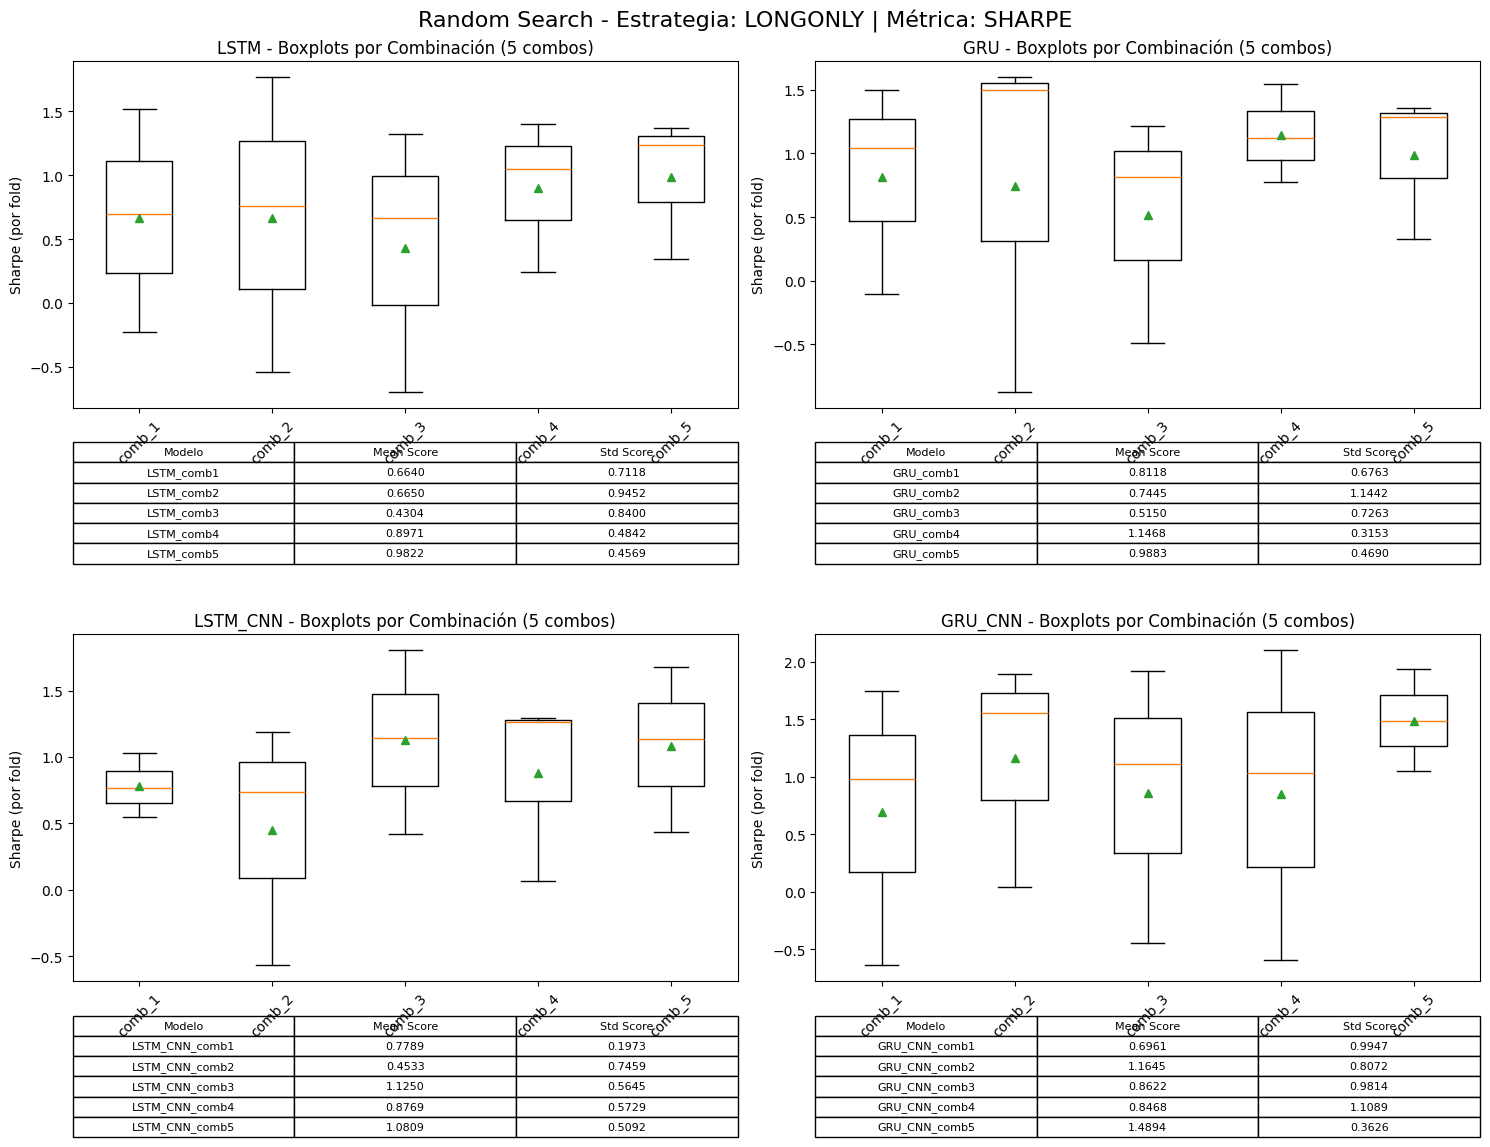

Mejor score: 1.4894369022911047
Mejores parámetros: {'model_type': 'GRU_CNN', 'strategy': 'longonly', 'learning_rate': 0.005, 'batch_size': 16, 'epochs': 30, 'dropout': 0.3, 'lstm_units': 64, 'cnn_filters': 16, 'kernel_size': 2}
  model_type  mean_score  std_score  n_folds  strategy  \
0       LSTM    0.663959   0.711815        3  longonly   
1        GRU    0.811783   0.676251        3  longonly   
2   LSTM_CNN    0.778931   0.197321        3  longonly   
3    GRU_CNN    0.696065   0.994675        3  longonly   
4       LSTM    0.664953   0.945225        3  longonly   

                                         fold_scores  learning_rate  \
0  [1.5173093444951222, -0.22517338449198399, 0.6...         0.0001   
1  [1.0461202933991625, -0.10837306907360109, 1.4...         0.0001   
2  [1.0283115414184911, 0.762684382681531, 0.5457...         0.0001   
3  [1.746738552969114, -0.6392910395725131, 0.980...         0.0001   
4  [1.771439195985889, -0.5378600068600426, 0.761...         0.0001

In [319]:
# Asegúrate que tu DataFrame tenga 'Target' y 'Return'
df_bitcoin["Open time"] = pd.to_datetime(df_bitcoin["Open time"])
df_bitcoin = df_bitcoin.set_index("Open time")
df_bitcoin["Return"] = np.log(df_bitcoin["Close"] / df_bitcoin["Close"].shift(1)).fillna(0)

# Ejecutar la búsqueda - longonly
results = run_time_series_random_search(
    df_bitcoin,
    target_col="Target",
    return_col="Return",
    window_size=30,
    horizon=1,
    test_size=0.2,
    strategy="longonly",   # longonly | shortonly | longshort
    scoring="sharpe",      # sharpe | accuracy | f1 | ...
    n_iter=5               # número de combinaciones a probar
)


# Revisar mejores parámetros y score
print("Mejor score:", results.best_score_)
print("Mejores parámetros:", results.best_params_)

# Ver el DataFrame con todos los resultados
results_df = results.get_results_df()
print(results_df.head())
